In [85]:
# Start coding here...
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

pd.set_option('display.max_columns', None)
seed = 42

df = pd.read_csv('recipe_site_traffic_2212.csv')

## Data Validation
This dataset contains basic recipe information that includes the unique recipe id, amounts in grams for calories, carbohydrate, sugar, and protein, the number of servings, the recipe's category, and whether the recipe generated high traffic or not. To validate and clean this data, I first described its summary statistics and checked the information.

In [86]:
print(df.describe())
print(df.info())

           recipe     calories  carbohydrate       sugar     protein
count  947.000000   895.000000    895.000000  895.000000  895.000000
mean   474.000000   435.939196     35.069676    9.046547   24.149296
std    273.519652   453.020997     43.949032   14.679176   36.369739
min      1.000000     0.140000      0.030000    0.010000    0.000000
25%    237.500000   110.430000      8.375000    1.690000    3.195000
50%    474.000000   288.550000     21.480000    4.550000   10.800000
75%    710.500000   597.650000     44.965000    9.800000   30.200000
max    947.000000  3633.160000    530.420000  148.750000  363.360000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein     

The summary statistics indicated that there might be some outliers in the numeric columns, but there were no negatives or otherwise impossible values. The datasets information indicated that there were 52 missing values in the numeric columns (calories, carbohydrate, sugar, and protein), and 373 missing values in high_traffic.

In [87]:
# 52 NaN values in calories, carbohydrate, sugar, and protein
# 373 NaN values in target variable high_traffic. Infer these mean that traffic is not high. Thereby, 373 "not high traffic" records and 574 "high traffic" records.
print(df.head())
print(df[df.duplicated()])  # No duplicates

   recipe  calories  carbohydrate  sugar  protein   category servings  \
0       1       NaN           NaN    NaN      NaN       Pork        6   
1       2     35.48         38.56   0.66     0.92     Potato        4   
2       3    914.28         42.68   3.09     2.88  Breakfast        1   
3       4     97.03         30.56  38.63     0.02  Beverages        4   
4       5     27.05          1.85   0.80     0.53  Beverages        4   

  high_traffic  
0         High  
1         High  
2          NaN  
3         High  
4          NaN  
Empty DataFrame
Columns: [recipe, calories, carbohydrate, sugar, protein, category, servings, high_traffic]
Index: []


Starting with high_traffic, the unique values are only "High" (574) and NaN (373), indicating that every NaN suggests that the recipe did not produce high traffic. I replaced this column's NaN values with 0 and its "High" values with 1, allowing it to be used as the target variable for a classification model. For each of the numeric columns, I imputed their medians.

In [88]:
# Convert NaN values for high_traffic to boolean 1 / 0.
df['high_traffic'] = np.where(df['high_traffic'] == 'High', 1, 0)

# Impute numerical columns with the median
df = df.fillna({'calories': df['calories'].median(), 'carbohydrate': df['carbohydrate'].median(), 'sugar': df['sugar'].median(), 'protein': df['protein'].median()})

I noticed also that the servings column has the data type of object. Inspecting its value counts, there are 3 instances where the serving count is followed by a string "as a snack." Since the category already indicates that the recipe is a snack, I removed that string and converted the column to an integer data type.

In [89]:
print(df[['category']].value_counts(dropna=False))

# Remove string text from Servings and convert to integer
# Should Servings be turned into dummy variables or left as int?
servings = df['servings'].str.split(' ', n=1, expand=True)
df['servings'] = servings[0].astype(int)

category      
Breakfast         106
Chicken Breast     98
Beverages          92
Lunch/Snacks       89
Potato             88
Pork               84
Dessert            83
Vegetable          83
Meat               79
Chicken            74
One Dish Meal      71
dtype: int64


 Next, I checked the category column's value counts and found that there were 11 total columns rather than the 10 specified in the report request. I found "Chicken Breast" and "Chicken" as separate categories, so I consolidated them into "Chicken."

In [90]:
# Change Chicken Breast to Chicken in Category column (not listed in 10 categoies provided)
df['category'] = df['category'].apply(lambda x: 'Chicken' if x == 'Chicken Breast' else x)
category_order = df['category'].value_counts().index

# Review category values
print(df[['category']].value_counts(dropna=False))

category     
Chicken          172
Breakfast        106
Beverages         92
Lunch/Snacks      89
Potato            88
Pork              84
Dessert           83
Vegetable         83
Meat              79
One Dish Meal     71
dtype: int64


Finally, I one-hot encoded the categories so that they can be used in a classification model.

In [91]:
# Convert category into dummy variables
df_dummies = pd.get_dummies(df['category'], drop_first=True)
df_dummies = pd.concat([df, df_dummies], axis=1)
df_dummies = df_dummies.drop('category', axis=1)

In [92]:
print(df.head())
print(df_dummies.head())

   recipe  calories  carbohydrate  sugar  protein   category  servings  \
0       1    288.55         21.48   4.55    10.80       Pork         6   
1       2     35.48         38.56   0.66     0.92     Potato         4   
2       3    914.28         42.68   3.09     2.88  Breakfast         1   
3       4     97.03         30.56  38.63     0.02  Beverages         4   
4       5     27.05          1.85   0.80     0.53  Beverages         4   

   high_traffic  
0             1  
1             1  
2             0  
3             1  
4             0  
   recipe  calories  carbohydrate  sugar  protein  servings  high_traffic  \
0       1    288.55         21.48   4.55    10.80         6             1   
1       2     35.48         38.56   0.66     0.92         4             1   
2       3    914.28         42.68   3.09     2.88         1             0   
3       4     97.03         30.56  38.63     0.02         4             1   
4       5     27.05          1.85   0.80     0.53         4   

## Exploratory Analysis
I noted that the numeric columns (calories, carbohydrate, sugar, and protein) may have outliers, judging by their max values in comparison to their medians, so I inspected these outliers using a z score of greater than 3. Although the values are quite large, and rather unhealthy, they were not outliers. Furthermore, it is not improbable that these recipes could provide that large of nutrient values.

In [93]:
numeric_col = ['calories', 'carbohydrate', 'sugar', 'protein']

z_scores = np.abs(stats.zscore(df[numeric_col]))
outliers = df[(z_scores > 3).all(axis=1)]
print(outliers)

Empty DataFrame
Columns: [recipe, calories, carbohydrate, sugar, protein, category, servings, high_traffic]
Index: []


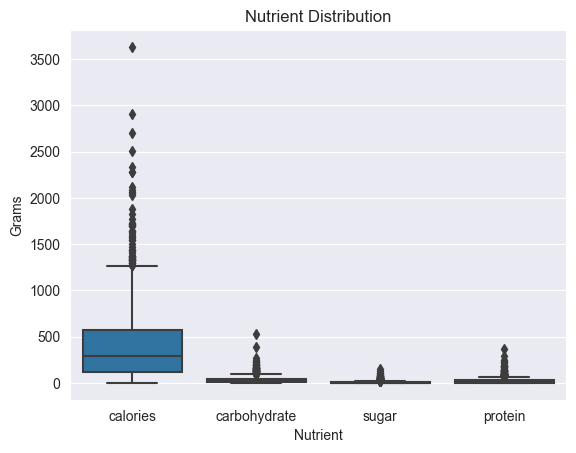

In [94]:
df_melted = pd.melt(df, value_vars=numeric_col)
sns.boxplot(data=df_melted, x='variable', y='value')
plt.xlabel('Nutrient')
plt.ylabel('Grams')
plt.title('Nutrient Distribution')
plt.show()

I also divided each of the numeric columns by the number of servings to see if it was possible that the higher number of servings were skewing the nutrient amounts, but this was not the case.

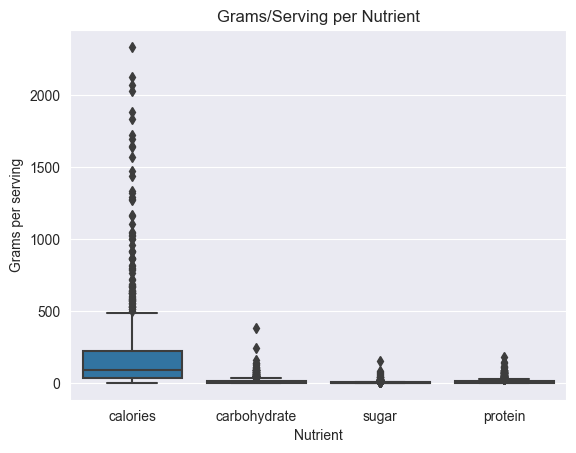

In [95]:
# Convert nutrition numbers to a ratio of serving.
for col in numeric_col:
    df[col] = df[col] / df['servings']

df_melted = pd.melt(df, value_vars=numeric_col)
sns.boxplot(data=df_melted, x='variable', y='value')
plt.xlabel('Nutrient')
plt.ylabel('Grams per serving')
plt.title('Grams/Serving per Nutrient')
plt.show()

However, I did leave the numeric columns adjusted by the number of servings and removed servings prior to finishing the preprocessing for the classification model. In inspecting the correlation matrix for this dataset, those numeric columns had the highest correlation with servings. Although it was still moderate in size (between -0.28 and -0.45), it is both sensible and significant enough to standardize the nutrients and remove servings.

C:\Users\Mikey\AppData\Local\Temp\ipykernel_233552\15596110.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True)


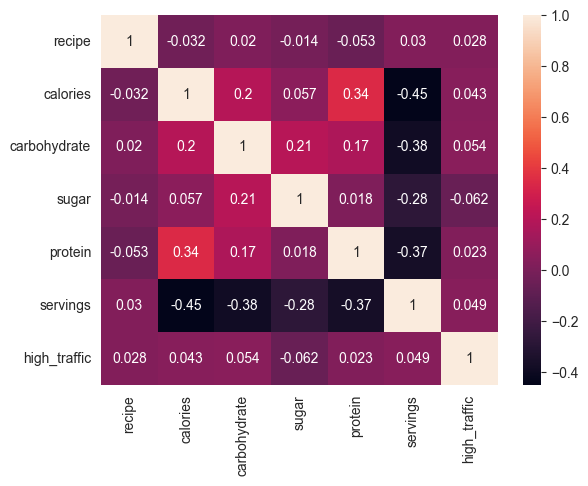

In [96]:
# Plot correlation
sns.heatmap(df.corr(), annot=True)
plt.show()

Next, I inspected the category column and plotted the counts for each category.

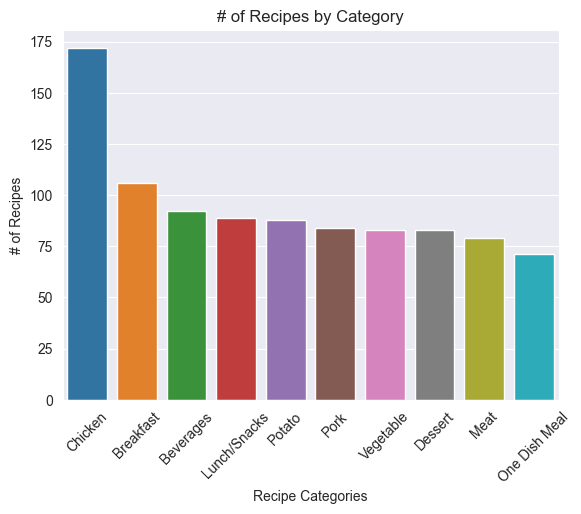

In [97]:
sns.countplot(data=df, x='category', order=category_order)
plt.xticks(rotation=45)
plt.xlabel('Recipe Categories')
plt.ylabel('# of Recipes')
plt.title('# of Recipes by Category')
plt.show()

Finally, I checked the count of high traffic recipes against low traffic recipes.

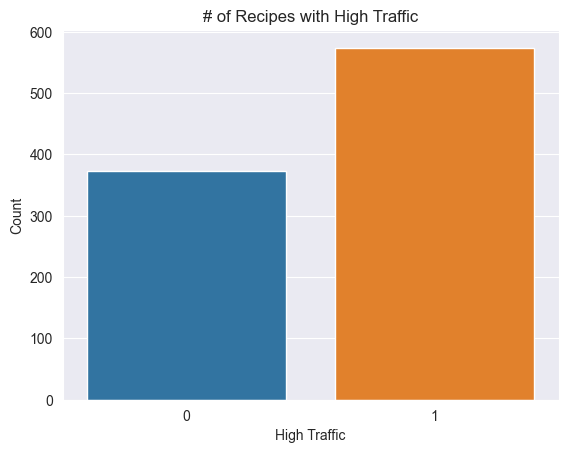

In [98]:
# Insert column plot
sns.countplot(data=df, x='high_traffic')
plt.xlabel('High Traffic')
plt.ylabel('Count')
plt.title('# of Recipes with High Traffic')
plt.show()

## Model Development
Tasty Bytes is interested in predicting which recipes will lead to high traffic, suggesting that this is a predictive classification problem. The classification is whether the recipe generates high traffic or not, making **high_traffic** our target variable.

The chosen model must predict high traffic recipes at least 80% of the time, so the metric we are interested in measuring is **precision**. Precision meaures the proportion of true positive predictions (high traffic recipes) among all positive predictions made by the model. In this context, maximizing precision will help minimize the chances of showing unpopular recipes (false positives).

In [99]:
# Predictive Classification problem
X = df_dummies.drop(['high_traffic', 'servings'], axis=1)
y = df_dummies['high_traffic']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed)

I started by creating a baseline Logistic Regression model after splitting the dataset into a 20/80 test/train split, which produced a baseline precision score of 0.6053 or 60.53% precision.

In [100]:
# Instantiate baseline model
baseline_model = DummyClassifier(strategy='most_frequent')
baseline_model.fit(X_train, y_train)
y_pred_baseline = baseline_model.predict(X_test)
baseline_precision = precision_score(y_test, y_pred_baseline)

Next, I instantiated 3 models with varying parameters: Logistic Regression, K-Nearest Neighbors, and a Decision Tree Classifier. I ensured to standardize the data using a standard scaler and to use a grid search cross validation technique to maximize the predictive accuracy of the model.

In [101]:
# Instantiate comparison model
models = {
    'Logistic Regression': LogisticRegression(random_state=seed),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=seed)
}

param_grid = [
	{
		'classifier': [LogisticRegression(random_state=seed)],
		'classifier__C': np.arange(0.001, 1.1, 0.1)
	},
	{
		'classifier': [KNeighborsClassifier()],
		'classifier__n_neighbors': np.arange(1, 25, 3)
	},
	{
        'classifier': [DecisionTreeClassifier(random_state=seed)],
        'classifier__max_depth': [None, 10, 20, 30, 40, 50],
        'classifier__min_samples_leaf': [1, 2, 5, 10, 20, 0.05, 0.1, 0.2, 0.25],
        'classifier__max_features': [None, 'sqrt', 'log2', 0.2, 0.5, 0.8]
	}
]

best_models= {}

for model_name, model in models.items():
    steps = [
        ('scaler', StandardScaler()),
        ('classifier', model)
    ]
    pipeline = Pipeline(steps)
    grid_search = GridSearchCV(pipeline, param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    best_models[model_name] = {
        'best_estimator': grid_search.best_estimator_,
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_
    }

best_model_name = max(best_models, key=lambda k: best_models[k]['best_score'])
best_model_info = best_models[best_model_name]
best_model_cv_score = best_model_info['best_score']
best_model = best_model_info['best_estimator']

new_model = best_model
new_model.fit(X_train, y_train)
y_pred = new_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

#Precision measures the proportion of true positive predictions (high traffic recipes) among all positive predictions made by the model.
#In this context, maximizing Precision will help minimize the chances of showing unpopular recipes (false positives)

In [102]:
print(best_model_name)
print(f'Baseline Precision: {baseline_precision}')
print(f'{best_model_name} Precision: {precision}')

Logistic Regression
Baseline Precision: 0.6052631578947368
Logistic Regression Precision: 0.8380952380952381


In [103]:
precision_dict = {'Baseline': baseline_precision, best_model_name: precision}
data = list(precision_dict.items())
labels, values = zip(*data)
print(precision_dict)
print(best_model)

{'Baseline': 0.6052631578947368, 'Logistic Regression': 0.8380952380952381}
Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', LogisticRegression(C=0.201, random_state=42))])


## Model Evaluation
After testing a series of models, the Logistic Regression model (with a parameter of C=0.201) produced the best precision score 0.8381 or 83.81%, above the required 80%.

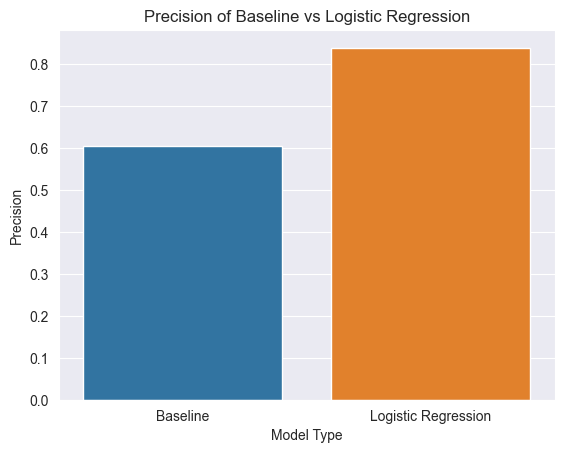

In [104]:
precision_df = pd.DataFrame(list(precision_dict.items()), columns=['Model Type', 'Precision'])

sns.barplot(data=precision_df, x='Model Type', y='Precision')
plt.xlabel('Model Type')
plt.ylabel('Precision')
plt.title(f'Precision of Baseline vs {best_model_name}')
plt.show()

In inspecting the confusion matrix for the test predictions, we see that the model correctly predicted 88 high traffic recipes out of the total high traffic predictions of 107. It performed a bit worse predicting the low traffic recipes (56 out of 83), but that is okay since we are not interested in knowing which recipes would generate low traffic as we are already ignoring them.

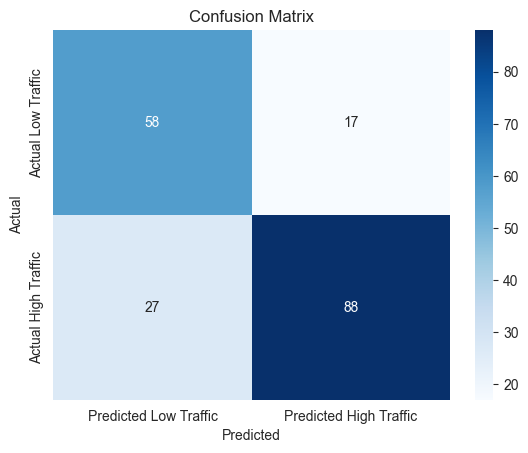

In [105]:
conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Low Traffic', 'Predicted High Traffic'], yticklabels=['Actual Low Traffic', 'Actual High Traffic'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Metrics to Monitor
The key metric to monitor for this business case is precision. As previously stated, precision shows the model's ability to predictive which recipes will generate high traffic, which is the most important prediction that the model can make. However, it might be worthwhile to also measure the accuracy score and f1 score. These metrics provide more information about how good the model is at all of its prediction, where accuracy measures the model's correct predictions over all its predictions, and f1 measures the average of the model's precision and recall score.

In [106]:
acc_results = {
    'Model': [best_model_name],
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1': [f1]
}

results_df = pd.DataFrame(acc_results)
print(results_df)

                 Model  Accuracy  Precision    Recall   F1
0  Logistic Regression  0.768421   0.838095  0.765217  0.8


This model had an accuracy of 76.84% and a f1 score of 80%. If new features are added to the dataset, it might be helpful to see how these models change with the new features.

Lastly, it would be beneficial to track how the count of subscribers and the traffic volume both change as a result of using this model for future recipes. This dataset does not provide insights into those metrics.

## Final Summary
My recommendation for Tasty Bytes is to adopt this model and to continue using it for guiding which recipes to post. First, I would advise splitting up some upcoming recipes into a control group, selecting one group's recipes by hand (the traditional way) and the other group's recipes using the model, and testing the statistical significance of the recommended recipes' traffic generation. However, the model may be useful regardless of its significance given the current uncertainty about which recipes to post, suggesting they are posted at random. Continue to measure the traffic and subscriber count after posting the model's recommended recipes to see the lift that the model generates.

I would strongly suggest Tasty Bytes to increase the number of actionable features that are added to the recipe dataset. Features such as the time to make and cost per serving might greatly influence whether the recipe generates high traffic or not, but the current dataset does not track this information. If the new features are added, this model can be adjusted and the precision score (along with accuracy and f1, if desired) can be measured to determine the effects on the model's predictive performance.